In [1]:
# Set up drive and colab for reading files from shared drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports and installation of additional packages

import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob

from tensorflow.keras import Input, layers, optimizers
from tensorflow.keras.preprocessing import sequence, image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, add
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.utils import plot_model


from random import randint
!pip install datasets
from datasets import load_metric
import nltk
from nltk import word_tokenize
from nltk.translate.bleu_score import corpus_bleu

from PIL import Image

nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install transformers
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from tensorflow.keras.metrics import CosineSimilarity

from tqdm import tqdm
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 9.2 MB/s 
     |████████████████████████████████| 212 kB 69.3 MB/s 
     |████████████████████████████████| 101 kB 11.3 MB/s 
     |████████████████████████████████| 115 kB 77.7 MB/s 
     |████████████████████████████████| 141 kB 74.0 MB/s 
     |████████████████████████████████| 596 kB 55.3 MB/s 
     |████████████████████████████████| 127 kB 79.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 60.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 1.3 MB 54.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ea7e80fcb663d6fe84b81b5f1fde83729c1346659088238f54aba765c7d9f685
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
#Variables for file paths
glove_path = '/content/drive/Shareddrives/612 Project Shared Drive/glove6b'

# File paths for Flickr8k dataset
#file_model = '/content/drive/Shareddrives/612 Project Shared Drive/model_Flickr8k.pkl' # save the model to pickle
#token_path = "/content/drive/Shareddrives/612 Project Shared Drive/Flickr8k_text/Flickr8k.token.txt" # Contains descriptions for image id
#train_images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flickr8k_text/Flickr_8k.trainImages.txt' # file with train images ids
#test_images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flickr8k_text/Flickr_8k.testImages.txt' # file with test images ids
#images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flicker8k_Dataset/' # folder with all images

# File paths for Flickr30k dataset
file_image_feature_train = '/content/drive/Shareddrives/612 Project Shared Drive/image_features_train_30k.pkl'
file_image_feature_test = '/content/drive/Shareddrives/612 Project Shared Drive/image_features_test_30k.pkl'
file_model = '/content/drive/Shareddrives/612 Project Shared Drive/model_Flickr30k.pkl'
token_path = "/content/drive/Shareddrives/612 Project Shared Drive/Flickr30k_text/Flickr30k.token.txt" # Contains descriptions for image id
train_images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flickr30k_text/Flickr_30k.trainImages.txt' # file with train images ids
test_images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flickr30k_text/Flickr_30k.testImages.txt' # file with test images ids
images_path = '/content/drive/Shareddrives/612 Project Shared Drive/Flicker30k_Dataset/' # folder with all images


In [4]:
# Get dataset for images and ids prepared

def get_images_id(train_images_path):
    # load all the training image ids in a variable train from the trainImages.txt file
    doc = open(train_images_path,'r').read()
    dataset = list()
    for line in doc.split('\n'):
        if len(line) > 1:
            identifier = line.split('.')[0]
            dataset.append(identifier)
    return set(dataset)

def get_images_paths(path, images_path, img):
    # save all the training and testing image path name in train_img and test_img lists respectively
    t_images = set(open(path, 'r').read().strip().split('\n'))
    t_img = []
    for i in img: 
        if i[len(images_path):] in t_images:
            t_img.append(i)
    return t_img

train = get_images_id(train_images_path) # set of train images id
test = get_images_id(test_images_path) # set of test images id

img = glob.glob(images_path + '*.jpg')
train_img = get_images_paths(train_images_path, images_path, img) # list of path of train images
test_img = get_images_paths(test_images_path, images_path, img) # list of path of test images

In [5]:
# Clean train descriptions

def import_descriptions(token_path):
    # Open file with descriptions for image id
    doc = open(token_path,'r').read()
    # Create dictionary with image_id as key and the list of captions as value
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)
    return descriptions

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc] # lowercase
            desc = [w.translate(table) for w in desc] # remove punctuation
            desc = [word for word in desc if len(word)>1] # remove hanging 's' and 'a'
            desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
            joint = ' '.join(desc)
            desc_list[i] =  joint.strip() # remove trailing spaces
    return descriptions
    
def format_descriptions(descriptions):
    # save the image ids and their new cleaned captions in the same format as the token.txt file
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    new_descriptions = '\n'.join(lines)
    return new_descriptions

def add_tokens(descriptions, set_ids):
    # load the descriptions of the training images into a dictionary
    # adding two tokens in every caption, which are ‘startseq’ and ‘endseq’
    train_descriptions = dict()
    for line in descriptions.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in set_ids:
            if image_id not in train_descriptions:
                train_descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            train_descriptions[image_id].append(desc)
    return train_descriptions

def get_captions_from_dict(dictionary):
    # Create a list of all the training captions
    list_captions = []
    for key, val in dictionary.items():
        for cap in val:
            list_captions.append(cap)
    return list_captions

def get_max_len(descriptions):
    # find out what the max length of a caption can be since we cannot have captions of arbitrary length
    # if caption max length too large, it is set as 35 maximum
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    lines = all_desc
    result = max(len(d.split()) for d in lines)
    if (result > 35):
        return 35
    else:
        return result

descriptions = import_descriptions(token_path)
print('Raw descriptions: ', descriptions['1000092795']) # Flickr30k: 1000092795 - Flickr8k: 1000268201_693b08cb0e
cleaned_descriptions = clean_descriptions(descriptions)
print('Cleaned descriptions: ', cleaned_descriptions['1000092795'])  # Flickr30k: 1000092795 - Flickr8k: 1000268201_693b08cb0e
formatted_descriptions = format_descriptions(cleaned_descriptions)
print('Formatted descriptions: ', formatted_descriptions[0:348])
tokenized_train_descriptions = add_tokens(formatted_descriptions, train)
print('Tokenized train descriptions: ', tokenized_train_descriptions['1000092795'])  # Flickr30k: 1000092795 - Flickr8k: 1000268201_693b08cb0e
max_length = get_max_len(tokenized_train_descriptions)
print('Description Length: %d' % max_length)
all_train_captions = get_captions_from_dict(tokenized_train_descriptions)
print('List of captions: ', all_train_captions[0:5])

Raw descriptions:  ['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Two young , White males are outside near many bushes .', 'Two men in green shirts are standing in a yard .', 'A man in a blue shirt standing in a garden .', 'Two friends enjoy time spent together .']
Cleaned descriptions:  ['two young guys with shaggy hair look at their hands while hanging out in the yard', 'two young white males are outside near many bushes', 'two men in green shirts are standing in yard', 'man in blue shirt standing in garden', 'two friends enjoy time spent together']
Formatted descriptions:  1000092795 two young guys with shaggy hair look at their hands while hanging out in the yard
1000092795 two young white males are outside near many bushes
1000092795 two men in green shirts are standing in yard
1000092795 man in blue shirt standing in garden
1000092795 two friends enjoy time spent together
10002456 several men in hard hats are op
Tokenized train descriptio

In [6]:
# Create vocabulary

def create_vocab(descriptions):
    # create vocabulary of all the unique words in the captions
    vocabulary = set()
    for key in descriptions.keys():
            [vocabulary.update(d.split()) for d in descriptions[key]]
    return vocabulary

def clean_vocab(word_count_threshold, captions):
    # reduce our vocabulary to only those words which occur at least 10 times in the entire corpus
    word_counts = {}
    nsents = 0
    for sent in captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    return vocab

vocabulary = create_vocab(cleaned_descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))
cleaned_vocab = clean_vocab(10, all_train_captions)
print('Cleaned Vocabulary = %d' % (len(cleaned_vocab)))

Original Vocabulary Size: 19712
Cleaned Vocabulary = 4522


In [7]:
# Create mappings between words and index
ixtoword = {}
wordtoix = {}
ix = 1
for w in cleaned_vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

# Use GloVe embeddings to map the words to vectors
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
# Create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
%%time
# Note: This cell can be omitted during excecution and load the image features from the pkl files in the next cell
# Extract features from training images

# transfer learning using InceptionResNetV2 network which is pre-trained on the ImageNet dataset
model = InceptionResNetV2(weights='imagenet')

# remove the softmax layer from the pre-trained model, since we are not doing the classification part
model_new = Model(model.input, model.layers[-2].output)

# preprocess function to reshape the images to (299 x 299)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# encode training and testing images using the model defined above
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images_path):]] = encode(img)

In [8]:
# Save image features to file
#pickle.dump(encoding_train, open(file_image_feature_train, 'wb')) 
#pickle.dump(encoding_test, open(file_image_feature_test, 'wb'))

# Load image features from file
encoding_train = pickle.load(open(file_image_feature_train, 'rb'))
train_features = encoding_train
encoding_test = pickle.load(open(file_image_feature_test, 'rb'))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      904600      ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1536)         0           ['input_1[0][0]']                
                                                                                              

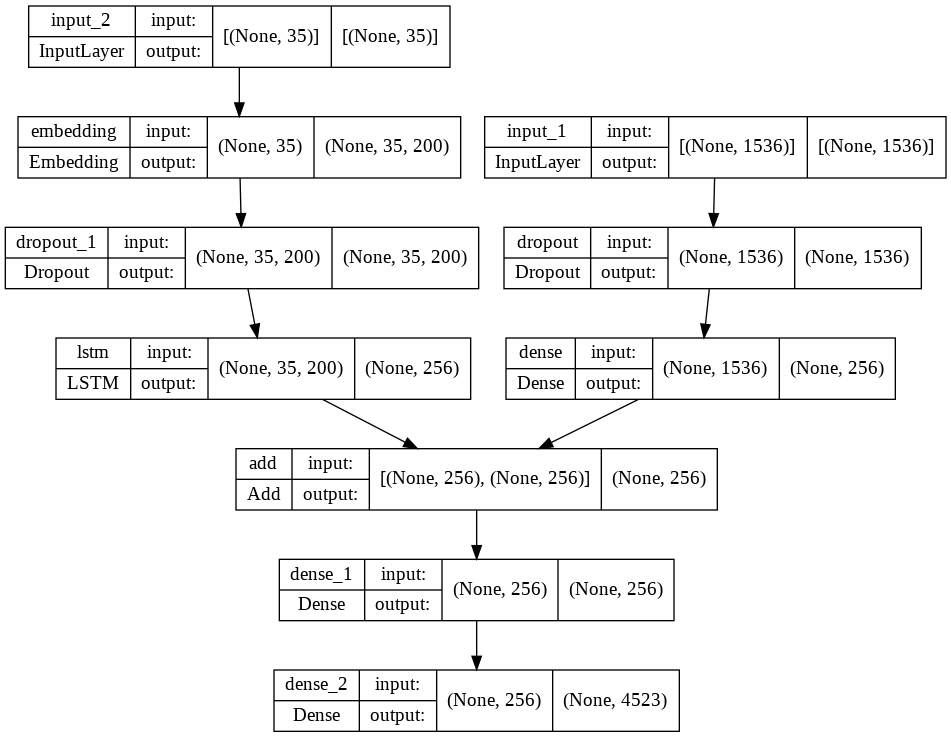

In [9]:
# Create model - for 30k we are using a model with less layers to avoid long runtime for each epoch
# First part of the model is the Image Model, which takes the image features as input
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
#fe3 = Dropout(0.5)(fe2)
#fe4 = Dense(256, activation='relu')(fe3)

# Second part of the model is the Language Model, which takes the embedded vectors of the captions as input
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2) # ,  return_sequences=True
#se4 = Dropout(0.5)(se3)
#se5 = LSTM(256)(se4)

# Final part of the model merges outputs of the two previous parts and generates final output of the model for predictions
#decoder1 = add([fe4, se5])
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()
plot_model(model, show_shapes=True)

In [10]:
# Model Training Set Up
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [11]:
# Function that prepares final training data for training the model
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
%%time
# Note: This cell can be omitted during excecution and load the trained model from the pkl file in the next cell
# Model Training 
#epochs = 100
#batch_size = 32
epochs = 10
batch_size = 128
steps = len(tokenized_train_descriptions)//batch_size

generator = data_generator(tokenized_train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [25]:
# Save model
# pickle.dump(model, open(file_model, 'wb'))
# Load model
model = pickle.load(open(file_model, 'rb'))

In [14]:
# Define functions for model evaluation

# Two methods for the caption generation are defined: greedy and beam search
def generate_caption_greedy(model, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def generate_caption_beam(model, image, max_length, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Function to generate captions with greedy method and calculate metrics for dataset of images
def evaluate_model(model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        # generate description
        yhat = generate_caption_greedy(model, photos[key+'.jpg'].reshape((1,1536)), max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('Bleu Cumulative 1-gram: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('Bleu Cumulative 2-gram: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('Bleu Cumulative 3-gram: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
    print('Bleu Cumulative 4-gram: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    #print('Meteor: ', round(nltk.translate.meteor_score.meteor_score(actual, predicted),4))
    
# Function that runs all metrics for one example image based on candidate and reference captions
def run_all_metrics(reference, candidate):
    #print('Bleu Individual 1-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(1, 0, 0, 0)))
    #print('Bleu Individual 2-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0, 1, 0, 0)))
    #print('Bleu Individual 3-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0, 0, 1, 0)))
    #print('Bleu Individual 4-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0, 0, 0, 1)))
    print('Bleu Cumulative 1-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(1, 0, 0, 0)))
    print('Bleu Cumulative 2-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0.5, 0.5, 0, 0)))
    print('Bleu Cumulative 3-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0.33, 0.33, 0.33, 0)))
    print('Bleu Cumulative 4-gram: %f' % sentence_bleu(reference, candidate.split(), weights=(0.25, 0.25, 0.25, 0.25)))
    print('Meteor: ', round(nltk.translate.meteor_score.meteor_score(reference, candidate.split()),4))

# Cosine similarity evaluation on test set - Set up
transformer_model = SentenceTransformer('stsb-roberta-large')
cosine_metric = CosineSimilarity(axis = -1)

# Define auxilary functions for cosine similarity
def get_predictions(model, descriptions, photos, max_length, images_path = images_path):
    predictions = list()
    references = list()
    for key, desc_list in tqdm(descriptions.items()):
        form_descs = []
        # generate description
        yhat = generate_caption_greedy(model, photos[key+'.jpg'].reshape((1,1536)), max_length)
        form_desc = desc_list[0].split()[1:-1]
        form_desc = " ".join(form_desc)
        # store predictions
        predictions.append(yhat)
        # store references
        references.append(form_desc)
    return (predictions, references)

def get_cosine_similarity(model, predictions, references): 
    cum_score = 0
    num_preds = len(predictions)
    
    encoded_preds = model.encode(predictions, convert_to_tensor=True).cpu()
    encoded_refs = model.encode(references, convert_to_tensor = True).cpu()

    cosine_metric.reset_state()  
    cosine_metric.update_state(encoded_preds, encoded_refs)
  
    score = cosine_metric.result().numpy
    return score

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
# Trained model will be evaluated on training images, test images and random individual images to review results 
# Get training set results and calculate metrics
evaluate_model(model, tokenized_train_descriptions, encoding_train, max_length)

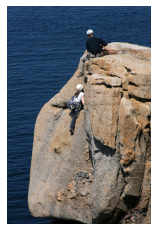

Generated Greedy Caption:  man in blue shirt and blue jeans is sitting on rock overlooking the water
Generated Beam K = 3 Caption:  man is sitting on the edge of rock
Generated Beam K = 5 Caption:  man is sitting on the edge of water
Generated Beam K = 7 Caption:  man and woman sitting on the edge of water
Generated Beam K = 10 Caption:  shirtless man is sitting on the edge of water
---------------------------------------
References for this image: [['one', 'climber', 'is', 'sitting', 'on', 'the', 'rock', 'overlooking', 'the', 'ocean', 'whilst', 'another', 'climber', 'is', 'on', 'her', 'way', 'up'], ['two', 'people', 'are', 'on', 'rock', 'overlooking', 'the', 'ocean'], ['two', 'people', 'climb', 'rock', 'overhanging', 'water'], ['two', 'people', 'climb', 'rocks', 'over', 'some', 'water'], ['two', 'people', 'rock', 'climbing', 'near', 'water']]
---------------------------------------
Results for greedy prediction: 
Candidate: man in blue shirt and blue jeans is sitting on rock overlooki

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [35]:
# Test model on random image from test set
# generate random id for choosing test photo
pic = list(encoding_test.keys())[randint(0, len(encoding_test))] # random photo
# Specific photos to check:
#pic = '2148916767.jpg' # Flickr30k: 2148916767 - Flickr8k: 2148916767_644ea6a7fa
pic = '801607443.jpg' # Flickr30k: 801607443 - Flickr8k: 801607443_f15956d1ce
#pic = '3558370311.jpg' # Flickr30k: 3558370311 - Flickr8k: 3558370311_5734a15890
#pic = '2308978137.jpg' # Flickr30k: 2308978137 - Flickr8k: 2308978137_bfe776d541

# get image
#image_random = encoding_train[pic].reshape((1,1536))
image_random = encoding_test[pic].reshape((1,1536))
# print image
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.axis('off')
plt.show()

# compute prediction of caption
caption_greedy = generate_caption_greedy(model, image_random, max_length)
print('Generated Greedy Caption: ', caption_greedy)
caption_beam_3 = generate_caption_beam(model, image_random, max_length, 3)
print('Generated Beam K = 3 Caption: ', caption_beam_3)
caption_beam_5 = generate_caption_beam(model, image_random, max_length, 5)
print('Generated Beam K = 5 Caption: ', caption_beam_5)
caption_beam_7 = generate_caption_beam(model, image_random, max_length, 7)
print('Generated Beam K = 7 Caption: ', caption_beam_7)
caption_beam_10 = generate_caption_beam(model, image_random, max_length, 10)
print('Generated Beam K = 10 Caption: ', caption_beam_10)

# Calculate metrics for sample random test image
reference = [
        descriptions[pic[:-4]][0].split(),
        descriptions[pic[:-4]][1].split(),
        descriptions[pic[:-4]][2].split(),
        descriptions[pic[:-4]][3].split(),
        descriptions[pic[:-4]][4].split()
]
print('---------------------------------------')
print('References for this image:', reference)
print('---------------------------------------')
print('Results for greedy prediction: ')
print('Candidate:', caption_greedy)
run_all_metrics(reference, caption_greedy)
print('---------------------------------------')
print('Results for beam 3 prediction: ')
print('Candidate:', caption_beam_3)
run_all_metrics(reference, caption_beam_3)
print('---------------------------------------')
print('Results for beam 5 prediction: ')
print('Candidate:', caption_beam_5)
run_all_metrics(reference, caption_beam_5)
print('---------------------------------------')
print('Results for beam 7 prediction: ')
print('Candidate:', caption_beam_7)
run_all_metrics(reference, caption_beam_7)
print('---------------------------------------')
print('Results for beam 10 prediction: ')
print('Candidate:', caption_beam_10)
run_all_metrics(reference, caption_beam_10)

In [26]:
# evaluate the model on all test dataset
# prepare test set
tokenized_test_descriptions = add_tokens(formatted_descriptions, test)
# evaluate model
evaluate_model(model, tokenized_test_descriptions, encoding_test, max_length)

100%|██████████| 7946/7946 [1:05:59<00:00,  2.01it/s]


Bleu Cumulative 1-gram: 0.471062
Bleu Cumulative 2-gram: 0.259264
Bleu Cumulative 3-gram: 0.145326
Bleu Cumulative 4-gram: 0.079067


In [27]:
# Get predictions for test set and calculate cosine similarity
%%time

(predictions, references) = get_predictions(model, tokenized_test_descriptions, encoding_test, max_length)
 
cosine_similarity_score = get_cosine_similarity(transformer_model, predictions, references)

100%|██████████| 7946/7946 [1:04:45<00:00,  2.04it/s]


CPU times: user 1h 5min 48s, sys: 2min 42s, total: 1h 8min 30s
Wall time: 1h 5min 54s


In [30]:
cosine_similarity_score

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.29895845>>